# Prediction Study on the Factors Associated with Total Violent Crime Numbers in California

#### Group member:&nbsp;&nbsp; Emily Ahn &nbsp; &nbsp; Xiaoran Fan &nbsp; &nbsp; Vicky Lin &nbsp; &nbsp; Chunyu Zhang      

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(infer)
library(cowplot)
library(GGally)
library(broom)
library(dplyr)
library(AER)
library(digest)
library(gridExtra)
library(caret)
library(pROC)
library(boot)
library(glmnet)
library(leaps)
library(faraway)
library(mltools)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: car

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some


Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: survival


Attaching package: ‘gridExtra’


The following obj

## Introduction

Nowadays, crime has become a severe problem around the world and is increasing in our society, making people feel anxious and unsafe all the time. Research showed many young people from US and Canadian colleges expressed being fearful of crime on and off campus (Leah E Daigle et al, 2021), which arises people’s thinking on the factors related to crime commission. According to National Research Council (2008), factors such as the state of economic opportunity, demographic groups and etc. may have a relationship with crime. Therefore, we decided to use the Communities and Crime Data Set acquired from UCI Machine Learning Repository by Michael Redmond to examine the predictive question: **For one specific state in US, California, among the factors of population density, young age rate, urbanization, income, poverty, education, unemployment, divorce rate and the number of people in a family, what variables can build up the best model to predict the total crime number?**
 
 
Our data set includes real data from socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. This dataset contains a total number of 128 attributes and 1994 instances. In our study, we will focus on one specific state in US, California, therefore we will use 278 instances of the data (which are instances of California). Moreover, according to Uniform Crime Report from FBI, we learnt that some potential variables such as income rate, poverty level and etc. may affect crime rate, therefore, we will not use all of the variables in the dataset but chose 11 variables based on the Uniform Crime Report to study (10 explanatory variables and 1 response variable). In this study, our focus is predictive, and we will use the linear regression and LASSO models to do the prediction study.

## Methods and Results

### Preliminary Results

#### Load Data

We first read the `communities.data` in data file and named it `crime_data`. 

In [2]:
set.seed(4)
crime_data <- read_csv("data/communities.data", col_names = FALSE)

head(crime_data)

Rows: 1994 Columns: 128
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (26): X2, X3, X4, X31, X102, X103, X104, X105, X106, X107, X108, X109, ...
dbl (102): X1, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,⋯,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,⋯,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,⋯,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,⋯,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,⋯,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,⋯,0.01,0.58,0.10,?,?,?,?,0.00,?,0.14


*Table 1.1 Raw dataset*

#### Clean and Wrangle Data

We find that, in some of the variables, not all of the values are completely collected, so we select the variables with no missed data.

Then we add the descripitions of each data we selected according to the `communities.names` file as follow:

- X1 -- `state`: US state (by number) - not counted as predictive above, but if considered, should be consided nominal (nominal)

- X6 -- `popComm`: population for community: (numeric - decimal)

- X14 -- `agePct16t24`: percentage of population that is 16-24 in age (numeric - decimal)

- X17 -- `pctUrban`: percentage of people living in areas classified as urban (numeric - decimal)<br>
      (In this variable, we are interested in whether or not there is people living in areas classified as urban, so we decide to change the datatype of this variable to categorical variable. We decide to classify the data with a percentage of 0 as `non-urban`, which means that *no one lives in an urban area*, and we classified the data with a percentage larger than 0 as `urban`, which means that *there are people living in cities*.)

- X26 -- `perCapInc`: per capita income (numeric - decimal)

- X34 -- `pctUnderPov`: percentage of people under the poverty level (numeric - decimal)

- X36 -- `pctNotHSGrad`: percentage of people 25 and over that are not high school graduates (numeric - decimal)

- X38 -- `pctUnemployed`: percentage of people 16 and over, in the labor force, and unemployed (numeric - decimal)

- X47 -- `pctDiv`: percentage of population who are divorced (numeric - decimal)

- X48 -- `meanPerFam`: mean number of people per family (numeric - decimal)

- X128 -- `totCrimesPerPop`: total number of violent crimes per 100K popuation (numeric - decimal) GOAL attribute (to be predicted)

We call the new dataset `crime` and print the first and last 6 rows in the `crime`.

We also count the total number of row in `crime` and assume it as the population of our research.

In [3]:
crime <- crime_data %>%
  select(X1,X6,X14,X17,X26,X34,X36,X38,X47,X48,X128)%>%
  rename(state = X1,
         popComm = X6,
         agePct16t24 = X14,
         pctUrban = X17,
         perCapInc = X26,
         pctUnderPov = X34,
         pctNotHSGrad = X36,
         pctUnemployed = X38,
         pctDiv = X47,
         meanPerFam = X48,
         totCrimesPerPop = X128)
crime$pctUrban <- if_else(crime$pctUrban > 0,
                 "urban","non-urban")
crime <- crime%>%
  mutate(pctUrban = as_factor(pctUrban))

head(crime)
tail(crime)
nrow(crime)

state,popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,0.19,0.29,urban,0.40,0.19,0.18,0.27,0.75,0.35,0.20
53,0.00,0.35,urban,0.37,0.24,0.24,0.27,1.00,0.29,0.67
24,0.00,0.28,non-urban,0.27,0.27,0.43,0.36,0.70,0.45,0.43
34,0.04,0.34,urban,0.36,0.10,0.25,0.33,0.44,0.75,0.12
42,0.01,0.23,urban,0.43,0.06,0.30,0.12,0.21,0.51,0.03
6,0.02,0.27,urban,0.72,0.12,0.12,0.10,0.58,0.44,0.14


state,popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28,0.02,0.43,non-urban,0.17,0.76,0.62,0.61,0.64,0.53,0.19
12,0.01,0.35,urban,0.49,0.16,0.11,0.12,0.53,0.35,0.09
6,0.05,0.73,urban,0.18,0.32,0.37,0.24,0.48,0.71,0.45
9,0.16,0.31,urban,0.31,0.31,0.58,0.50,0.52,0.47,0.23
25,0.08,0.63,urban,0.40,0.16,0.35,0.37,0.32,0.46,0.19
6,0.20,0.40,urban,0.24,0.35,0.55,0.47,0.57,0.86,0.48


[1] 1994

*Table 1.2 & 1.3 Dataset with variables of interest*

We want to do the study based on one specific state rather than all of the states. Also, we want the state has enough instances for us to study, therefore, we chose the state with the most instances.

In [4]:
state_crime <- crime %>%
group_by(state)%>%
count()
max = max(state_crime$n)
state_crime[which(state_crime['n'] == max),]

state,n
<dbl>,<int>
6,278


*Table 1.4 State with maximum size of instances*

As shown above, the state with area code 6, which is California (the name of corresponding state was not shown in the original data source but we searched it online), has the most instances. We `filter` out the instances of California and call the new dataset `clean_crime`. We will do our study based on `clean_crime`.

In [5]:
clean_crime <- crime %>%
filter(state == 6) %>%
select(-state)
head(clean_crime)

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,totCrimesPerPop
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.02,0.27,urban,0.72,0.12,0.12,0.10,0.58,0.44,0.14
0.01,0.36,non-urban,0.10,0.64,0.82,1.00,0.52,0.78,0.55
0.13,0.35,urban,0.33,0.18,0.36,0.32,0.46,0.85,0.24
0.04,0.30,urban,0.79,0.18,0.14,0.19,0.66,0.35,0.21
0.25,0.28,urban,0.29,0.34,0.43,0.59,0.67,0.60,0.34
0.02,0.39,non-urban,0.08,0.63,1.00,1.00,0.33,1.00,0.31


*Table 1.4 Dataset with variables of interest of California*

#### View Data Visually

We first want to have a look at the distribution of the response variable `totCrimesPerPop`. We use `geom_histogram` to plot the distribution.

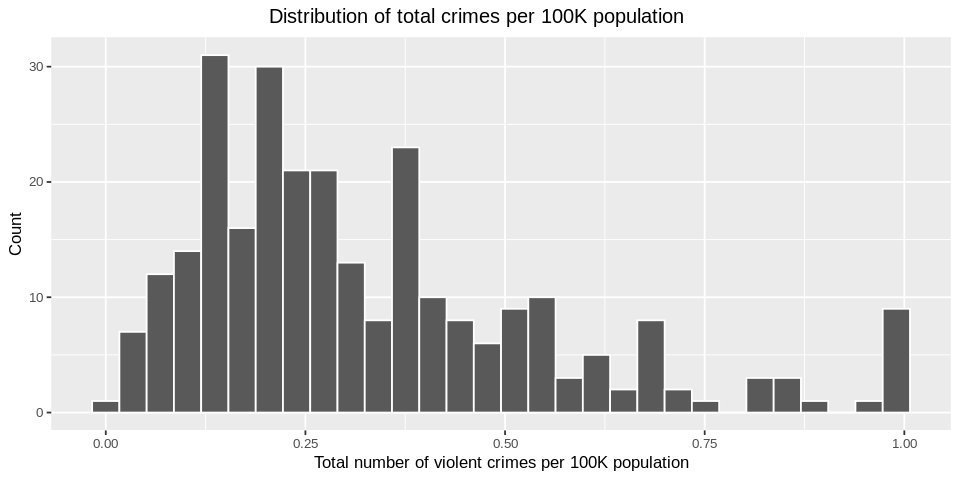

In [6]:
options(repr.plot.width = 8, repr.plot.height = 4)

tot_crime_dist <- clean_crime %>%
    ggplot(aes(x = totCrimesPerPop)) +
    geom_histogram(bins = 30, color = "white") +
    xlab("Total number of violent crimes per 100K population") +
    ylab("Count") +
    ggtitle("Distribution of total crimes per 100K population") +
    theme(text = element_text(size = 10)) +
    theme(plot.title = element_text(hjust = 0.45))
tot_crime_dist

*Figure 1.1 Distribution of total number of vioment crimes per 100K population*

The histogram above shows the distribution of total crimes per 100 thousand population with an asymmetry shape. The distribution is right-skewed with the most of the counts are in a roughly range between 12.5% and 37.5%. The reason why our population distribution is not symmetric and not normal may be the range of our response variable. Our response variable is a percentage whose range is from 0 to 1, but the prediction model should has an infinite range, so in our assumption checking below, we should use logarithm of the response variable `totCrimesPerPop`.

Then, we want to explore visually how each input variable is associated with the response variable, and whether there's any association between the input variables. We use the plotting function `ggpairs()`, from the library `GGally`, to generate a pair plot of ALL the variables found in `clean_crime`. The `ggplot()` object’s name is `crime_pair_plots`.

In [7]:
# options(repr.plot.width = 8, repr.plot.height = 8)

# crime_pair_plots <- clean_crime %>%
#     ggpairs(progress = FALSE, lower=list(combo = wrap("facethist", binwidth = 0.1))) +
#   theme(
#     text = element_text(size = 9.5),
#     plot.title = element_text(face = "bold"),
#     axis.title = element_text(face = "bold"),
#     axis.text.x = element_text(angle = 20, hjust = 1)
# )
# crime_pair_plots

*Figure 1.2 Pair plots of all variables*

**...[description of above ggpairs]**

We want to use boxplot to clearly visualize the relationship between `pctUrban` and `totCrimesPerPop`. We use `geom_boxplot()` to visualize their relationship.

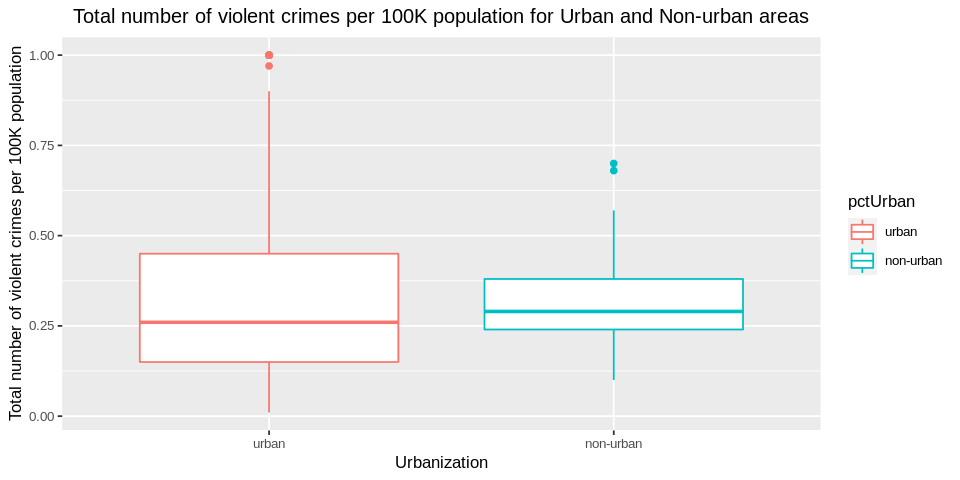

In [8]:
options(repr.plot.width = 8, repr.plot.height = 4)

urban_totCrime_boxplot <- 
    clean_crime %>%
    ggplot(aes(x = pctUrban, y = totCrimesPerPop , color = pctUrban)) +
    geom_boxplot() +
    xlab("Urbanization") +
    ylab("Total number of violent crimes per 100K population") +
    ggtitle("Total number of violent crimes per 100K population for Urban and Non-urban areas") +
    theme(text = element_text(size = 10)) +
    theme(plot.title = element_text(hjust = 0.5))

urban_totCrime_boxplot

*Figure 1.3 Boxplot of relationship between urbanization and total number of vioment crimes per 100K population*

This boxplot indicate the distribution of the total number of violent crimes per 100 thousands population for urban and non urban areas. The graph shows that the range of population of violent crimes in urbanization is larger and has a wider spread. But, the median number of the urban population and non urban population is close. Despite of some outliers are above the boxplots, the boxplot of the urban population shows a right-skewed shape while the boxplot of the non urban population shows a roughly normal distribution. If we use the categorical variable in the prediction model, we should use `non-urban` as the baseline of the dummy variable.

#### Statistics of Data

Next, we want to summarize the statistics of all of the continuous variables in our dataset and we call this summary table `crime_summary`.

In [9]:
crime_summary <-
    clean_crime %>%
    select(-pctUrban) %>%
    pivot_longer(cols = everything()) %>%
    group_by(name) %>% 
    summarise(
    mean = mean(value,na.rm = T),
    sd = sd(value,na.rm = T),
    median = median(value, na.rm = T),
    variance = var(value, na.rm = T),
    max = max(value, na.rm = T),
    min = min(value, na.rm = T))

crime_summary

name,mean,sd,median,variance,max,min
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
agePct16t24,0.33406475,0.1373223,0.310,0.01885743,1.00,0.09
meanPerFam,0.59312950,0.2219651,0.575,0.04926851,1.00,0.08
pctDiv,0.55500000,0.1502267,0.550,0.02256805,0.92,0.08
pctNotHSGrad,0.37967626,0.2516220,0.335,0.06331361,1.00,0.02
pctUnderPov,0.27661871,0.1807827,0.230,0.03268239,0.86,0.02
pctUnemployed,0.38611511,0.2341064,0.330,0.05480579,1.00,0.02
perCapInc,0.40586331,0.2344757,0.350,0.05497885,1.00,0.02
popComm,0.08992806,0.1442471,0.050,0.02080722,1.00,0.00
totCrimesPerPop,0.33046763,0.2261883,0.265,0.05116115,1.00,0.01


*Table 1.5 Summary table of statistics of continuous variables*

From the summary table of the continuous variables, we can see that the `popCpmm` has the smallest mean value which is $ 8.99 $ %while the `meanPerFam` has the largest mean value which is $ 59.31 $ % the differences of the mean values of every countinuous variables is between $ 0 $ to $ 50.32 $%, it means the averages are different. The medians are similar to the means, the variable with the largest mean value also has the largest median value which is $ 57.5 $%, and the variable with the smallest mean value has the smallest median value which is $ 5.0 $%. The ranges of each variables are also significantly different, it lead to the different variances and syandard deviations.

Now, we have done the preliminary results. We will then start to analyze the data and select the predictive model. Before doing these, we need to do the model assuption checkings.

### Linear Regression Model Assumption Checkings

#### Check Heteroscedasticity Using Residuals-fitted Value Plot

To check heteroscedasticity, we first use `lm()` to estimate the regression parameters and assign the results to the object `crime_full_model`. 

Then we obtain the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals using `tidy()` and store the results in `crime_full_model_results`.

In [10]:
crime_full_model <- lm(totCrimesPerPop ~., data = clean_crime)
crime_full_model_results <- tidy(crime_full_model, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
crime_full_model_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.49,0.13,-3.83,0.00,-0.74,-0.24
popComm,0.26,0.07,3.66,0.00,0.12,0.40
agePct16t24,0.10,0.11,0.98,0.33,-0.10,0.31
pctUrbannon-urban,-0.10,0.03,-3.05,0.00,-0.17,-0.04
perCapInc,0.25,0.09,2.76,0.01,0.07,0.42
pctUnderPov,0.07,0.14,0.47,0.64,-0.22,0.35
pctNotHSGrad,0.34,0.10,3.31,0.00,0.14,0.55
pctUnemployed,0.26,0.12,2.07,0.04,0.01,0.50
pctDiv,0.54,0.09,6.04,0.00,0.36,0.72


*Table 1.6 Results of crime full model* 

So far, we are not going to interpret the computed results yet since our purpose is to check its heteroscedasticity. To detect heteroscedasticity, we look at residuals-fitted value plot for diagnosis. We use `plot()` function to get the visualization.

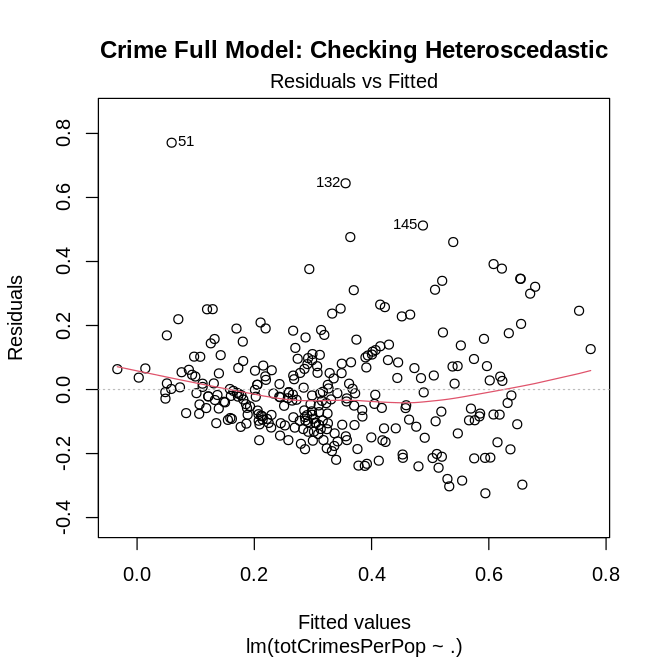

In [11]:
options(repr.plot.width = 5.5, repr.plot.height = 5.5)

plot(crime_full_model, 1, main = "Crime Full Model: Checking Heteroscedastic")

*Figure 1.4 Residuals-fitted Value Plot for checking heteroscedasticity*

According to  diagnosis rule, if the errors are homoscedastic (equal variance), the residuals should show equal variation for all fitted values. From the above residuals-fitted value plot, we observe that the diagnostic plot does not show a uniform and scattered cloud of points, which indicates a non-constant variance. It seems violate the rule and we want to remedy it. A common remedy is transformation of the response. Therefore, we use `log()` function to transform the original value of response to log value and we will repeat the above process again.

In [12]:
clean_crime_data <- clean_crime %>% mutate(log_totCrimesPerPop = log(totCrimesPerPop)) %>% select(- totCrimesPerPop)

In [13]:
crime_full_OLS <- lm(log_totCrimesPerPop ~., data = clean_crime_data)
crime_full_OLS_results <- tidy(crime_full_OLS, conf.int = TRUE) %>% mutate_if(is.numeric, round, 2)
crime_full_OLS_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.44,0.39,-8.73,0.00,-4.21,-2.66
popComm,0.77,0.22,3.49,0.00,0.33,1.20
agePct16t24,0.47,0.33,1.42,0.16,-0.18,1.11
pctUrbannon-urban,-0.17,0.10,-1.69,0.09,-0.37,0.03
perCapInc,-0.19,0.28,-0.69,0.49,-0.74,0.35
pctUnderPov,-0.09,0.45,-0.19,0.85,-0.97,0.80
pctNotHSGrad,1.29,0.32,4.00,0.00,0.65,1.92
pctUnemployed,0.24,0.39,0.63,0.53,-0.52,1.00
pctDiv,2.03,0.28,7.31,0.00,1.48,2.57


*Table 1.7 Results of crime full OLS*

We use `plot()` function to visualize the residuals-fitted value plot again for diagnosis.

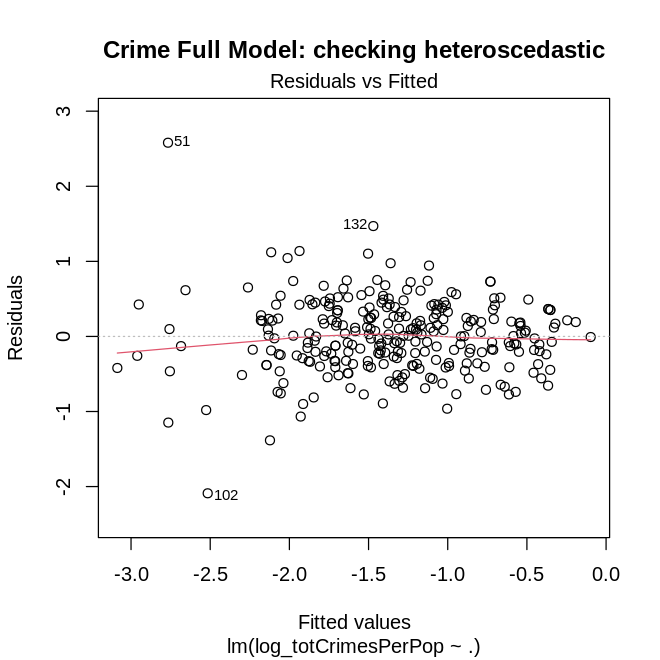

In [14]:
options(repr.plot.width = 5.5, repr.plot.height = 5.5)

plot(crime_full_OLS, 1, main = "Crime Full Model: checking heteroscedastic")

*Figure 1.5 Residuals-fitted Value Plot after transformation of the response* 

From the figure, we can see that each point is randomly distributed, and the residual of each fiitted value is around 0. There are 3 outliers marked 51, 102 and 132. The plot does not show any signs of funnel shape, so we can be sure that the errors are not heteroskedasticity.

After we done the transformation of the response, the diagnostic plot of `crime_full_OLS` shows a uniform and more scattered cloud of points than `crime_full_model`, and the residuals show equal variation for almost all fitted values. Now, we have checked the errors are independent and identically distributed.

#### Check Normality using $Q$-$Q$ plots and Histogram of Residuals

Next, we want to check the assumption that the error terms are normally distributed. To assess the normality assumption, we will look at the $Q$-$Q$ plot and the histogram of residuals. We obtain the $Q$-$Q$ plot using `plot()` function and histogram of residuals using `hist()` function. Since we transformed the response, we will use `crime_full_OLS` model for the plots.

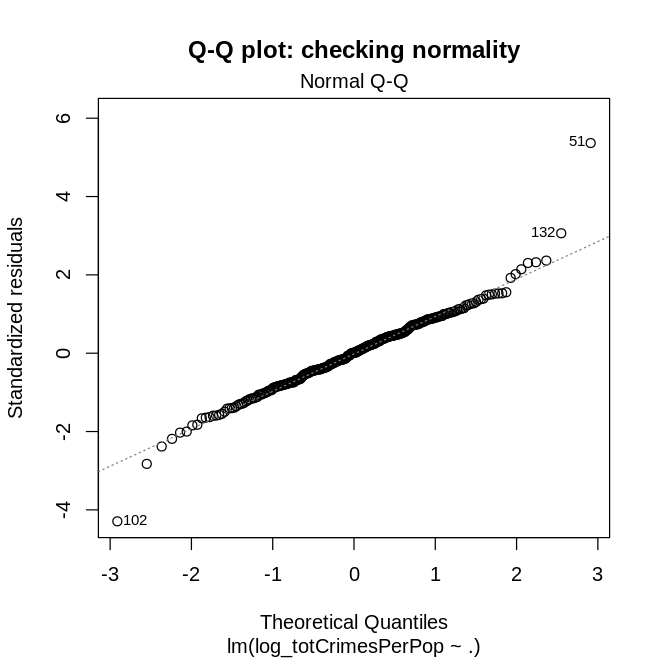

In [15]:
plot(crime_full_OLS, 2, main = "Q-Q plot: checking normality")

*Figure 1.6 Q-Q plot for checking normality*

In this plot, the points fall along a line in the middle, but curve off in the extremities. Also the outliers fall in the end of the line. This Q-Q plots that exhibit this behavior means the errors are nearly Normal distribution.

For `crime_full_OLS`, most of the points lie on the 45° degrees dotted line of the $Q$-$Q$ plot which suggest that the errors are normally distributed.

We also plot the histogram of residuals using `hist()` to estimate the distribution of the error term.

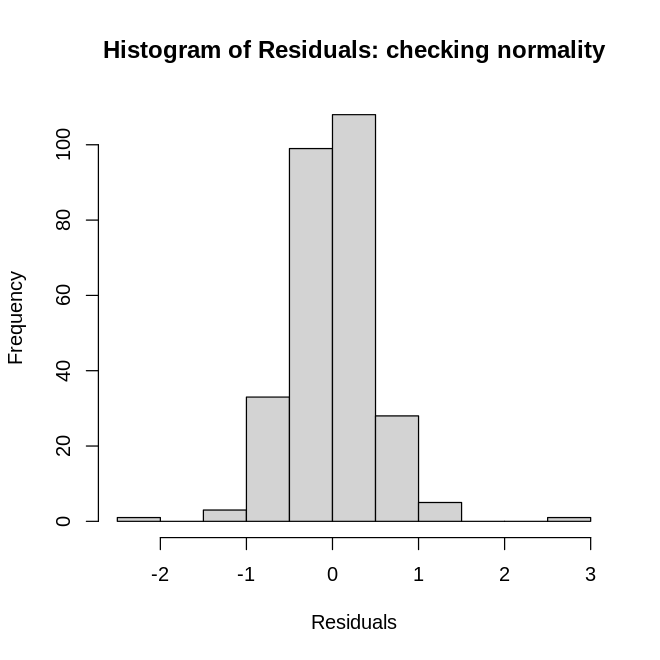

In [16]:
hist(residuals(object = crime_full_OLS),
  breaks = 10,
  main = "Histogram of Residuals: checking normality",
  xlab = "Residuals")

*Figure 1.7 Histogram of residuals for checking normality*

To observe the distribution of the data more clearly, we draw the histogram. This distribution is clearly a normal distribution centered at 0.

For `crime_full_OLS`, the histogram shows a bell-shaped distribution of residuals which also provides evidence that the errors are normally distributed. 

#### Check Multicollinearity using Variation Inflation Factors (VIF) 

First, we want to use heatmap to visualize pairwise correlation coefficients between all continuous input variables. 

We create a melted correlation matrix with all pairwise correlations between the continuous input variables of `clean_crime` using `cor()` function and name it `corr_matrix_crime`. 

In [17]:
corr_matrix_crime <- 
    clean_crime_data %>%
    select(- pctUrban, - log_totCrimesPerPop) %>%
    cor() %>%
    as.data.frame() %>%
    rownames_to_column("var1") %>%
    pivot_longer(- var1, names_to = "var2", values_to = "corr")
head(corr_matrix_crime)

var1,var2,corr
<chr>,<chr>,<dbl>
popComm,popComm,1.00000000
popComm,agePct16t24,0.10125574
popComm,perCapInc,-0.06563080
popComm,pctUnderPov,0.12584493
popComm,pctNotHSGrad,0.04808012
popComm,pctUnemployed,0.03843491


*Table 1.8 Melted correlation matrix with pairwise correlations between continuous input variables*

To create a correlation matrix on top of a heatmap using `corr_matrix_crime`, we use `geom_tile()` function from `ggplot2` and we round the correlation coefficients to 2 decimal places. We call this plot `plot_corr_matrix_crime`.

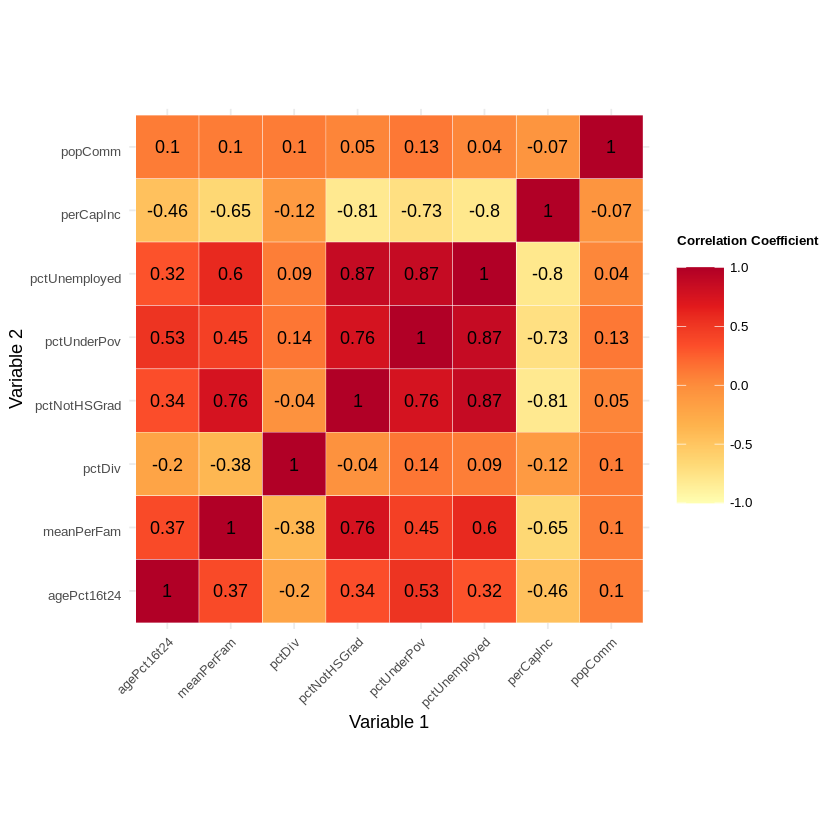

In [18]:
options(repr.plot.width = 7, repr.plot.height = 7)

plot_corr_matrix_crime <- corr_matrix_crime %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
    palette =  "YlOrRd",
    direction = 1, limits = c(-1,1)
  ) +
  labs(x = "Variable 1", y = "Variable 2") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(
      angle = 45, vjust = 1,
      size = 8, hjust = 1
    ),
    axis.text.y = element_text(
      vjust = 1,
      size = 8, hjust = 1
    ),
    legend.title = element_text(size = 8, face = "bold"),
    legend.text = element_text(size = 8),
    legend.key.size = unit(1, "cm")
  ) +
  coord_fixed() +
  geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 3.8)
plot_corr_matrix_crime


*Figure 1.8 Heatmap of correlation matrix*

Observing the above heatmap, we can see that some of the input variables are highly correlated (such as `pctUnemployed` and `pctNotHSGrad` which has a correlation coefficient of approximately 0.87), and this will lead to multicollinearity, a problem for the least square estimates of the linear regression coefficients, as well as for their standard errors.

We not only want to detect multicollinearity, we also want to know the extent of multicollinearity. To help quantify multicollinearity in our dataset, we will use Variance Inflation Factor (VIF). In `R`, we use `vif()` function to help us get VIF values.

In [19]:
VIF_crime_full_OLS <- vif(crime_full_OLS)

round(VIF_crime_full_OLS, 3)

popComm       agePct16t24 pctUrbannon-urban         perCapInc 
            1.143             2.324             1.501             4.794 
      pctUnderPov      pctNotHSGrad     pctUnemployed            pctDiv 
            7.432             7.448             9.316             1.970 
       meanPerFam 
            4.622

VIF ranges from 1 to infinity, where 1 indicates there is no multicollinearity. The larger the VIF, the greater the multicollinearity. From the computed VIF values, `pctUnemployed` is the variable with the highest VIF (which is 9.316), `pctUnderPov` and `pctNotHSGrad` also have higher VIF than other variables (which are 7.432 and 7.448 respectively). We discovered the variables with high VIF also have high absolute correlation from all the pairwise correlations shown in the heatmap `plot_corr_matrix_crime`. 

From what we learnt, one way to remedy the issue is to drop the input variables associated with the largest VIFs and pairwise correlation coefficients. However, we will not do it in this step since we will use model selection to select the ideal input variables in the model.

### Model Selection and Evaluation

We want to study three different models: full OLS model, reduced OLS model and LASSO model. We want to evaluate and select the best predictive model among these three models.

#### Splitting Traning data and Testing data

We start by randomly splitting `clean_crime_data` into two sets on a 70-30% basis: `crime_train` (70% of the data) and `crime_test` (the remaining 30% of the data), to test predictive model.

We create an `ID` column in `clean_crime_data` with the row number corresponding to each observation. Then, we use `slice_sample()` function to create the training data `crime_train` with 70% observations from `clean_crime_data`. After that, we use `anti_join()` function to create a testing data `crime_test` by column `ID`.

Next, we remove the `ID` column as we do not need this column in our model selection.

We compute the first six rows and the number of rows of `crime_train` and `crime_test` respectively, to check if we get correct number of observations in each dataset.

In [20]:
set.seed(4)

clean_crime_data$ID <- 1:nrow(clean_crime_data)
crime_train <- 
    slice_sample(clean_crime_data, prop = 0.70) 
    
crime_test <- 
    clean_crime_data %>%
    anti_join(crime_train, by = "ID")

crime_train <- crime_train %>% select(- "ID")
crime_test <- crime_test %>% select(- "ID")

head(crime_train)
nrow(crime_train)

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,log_totCrimesPerPop
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.07,0.31,urban,0.56,0.08,0.14,0.17,0.35,0.72,-1.6607312
0.20,0.43,urban,0.19,0.49,0.71,0.60,0.51,1.00,-0.4004776
0.04,0.45,urban,0.45,0.16,0.17,0.07,0.62,0.31,-1.0216512
0.02,0.25,urban,0.77,0.08,0.09,0.18,0.40,0.66,-1.8971200
0.02,0.23,non-urban,0.33,0.20,0.22,0.21,0.61,0.49,-1.9661129
0.55,0.37,urban,0.22,0.64,0.54,0.56,0.67,0.70,-0.5276327


[1] 194

*Table 1.9 the first six rows of training dataset*

In [21]:
head(crime_test)
nrow(crime_test)

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,log_totCrimesPerPop
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.13,0.35,urban,0.33,0.18,0.36,0.32,0.46,0.85,-1.4271164
0.02,0.39,non-urban,0.08,0.63,1.00,1.00,0.33,1.00,-1.1711830
0.06,0.32,urban,0.32,0.25,0.46,0.35,0.62,0.58,-0.1743534
0.03,0.26,urban,0.80,0.06,0.05,0.16,0.54,0.41,-2.5257286
0.05,0.24,non-urban,0.41,0.10,0.22,0.20,0.59,0.49,-1.5606477
0.02,0.13,urban,0.71,0.11,0.22,0.12,0.50,0.14,-2.3025851


[1] 84

*Table 1.10 the first six rows of testing dataset*

#### Full OLS Model

In the model assumption checking part, we have built a predictive additive LR `crime_full_OLS` with all 9 inputs, which is our baseline model, and also obtained the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals using `tidy()` function and stored the results in `crime_full_model_results`.

Now, we will look at our model `crime_full_OLS`and the results `crime_full_OLS_results`.

In [22]:
crime_full_OLS


Call:
lm(formula = log_totCrimesPerPop ~ ., data = clean_crime_data)

Coefficients:
      (Intercept)            popComm        agePct16t24  pctUrbannon-urban  
         -3.43734            0.76634            0.46658           -0.17307  
        perCapInc        pctUnderPov       pctNotHSGrad      pctUnemployed  
         -0.19176           -0.08534            1.28675            0.24316  
           pctDiv         meanPerFam  
          2.02658            0.47060  


**...[maybe interpretation?]**

In [23]:
crime_full_OLS_results

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.44,0.39,-8.73,0.00,-4.21,-2.66
popComm,0.77,0.22,3.49,0.00,0.33,1.20
agePct16t24,0.47,0.33,1.42,0.16,-0.18,1.11
pctUrbannon-urban,-0.17,0.10,-1.69,0.09,-0.37,0.03
perCapInc,-0.19,0.28,-0.69,0.49,-0.74,0.35
pctUnderPov,-0.09,0.45,-0.19,0.85,-0.97,0.80
pctNotHSGrad,1.29,0.32,4.00,0.00,0.65,1.92
pctUnemployed,0.24,0.39,0.63,0.53,-0.52,1.00
pctDiv,2.03,0.28,7.31,0.00,1.48,2.57


*Table 1.11 Results of predictive additive LR with all input variables*

**...[explanation about the data]**

Then we use `predict()` function and the predictive additive LR `crime_full_OLS` we just built to obtain the out-of-sample predicted values of total number of violent crimes per 100K popuation in testing data `crime_test`. We store the predicted values in a variable called `test_crime_full_OLS`. We will look at the first few predicted value using `head()` function.

In [24]:
test_crime_full_OLS <- predict(crime_full_OLS, newdata = crime_test)

head(test_crime_full_OLS)

1         2         3         4         5         6 
-1.379782 -0.812948 -1.118317 -2.061031 -1.789282 -2.115461

Now, we will compute the **root mean square error (RMSE)** using data from tests set `crime_test` to evalaute the predicted model. To compute the value of RMSE, we use `rmse()` function from the `mltools` package. `preds` are the predicted values stored in `test_crime_full_OLS`, while `actuals` are the observations from test set `crime_test`. We store the results in a table that has two columns: `Model` (the name of the regression model from which we obtain the prediction accuracy) and `R_MSE` (the $\text{RMSE}_{\text{test}}$ corresponding to the model.)

In [25]:
crime_R_MSE_pred_models <- tibble(
    Model = "OLS Full Regression",
    R_MSE = rmse(
        preds = test_crime_full_OLS,
        actuals = crime_test$log_totCrimesPerPop))

crime_R_MSE_pred_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,0.4123482


*Table 1.12 RMSE obtained from full OLS regression model*

The RMSE we computed is approximately 0.412, and we will compare this value with RMSE obtained from the other models to see which predictive model is the best.

#### Reduced OLS Model Obtained from Forward Selection

We have already got a predictive model using all input variables, but we want to see if there is a smaller model with fewer input variables may have better predictive performance.

Therefore, we want to select a reduced LR using the forward selection algorithm using our training set `crime_train`. To perform the forward selection, we use `regsubsets()` function from library `leaps`. In the function, the argument `x` is analogous to `formula` in `lm()`, so we just put `log_totCrimesPerPop ~ .` in it. As we have 9 input variables, we put `nvmax = 9`. We name the object `crime_forward_sel` and we use `summary()` to check our results. we call the results `crime_forward_summary`.

In [26]:
crime_forward_sel <- regsubsets(
    x = log_totCrimesPerPop ~., nvmax = 9,
    data = crime_train,
    method = "forward")

crime_forward_summary <- summary(crime_forward_sel)

crime_forward_summary

Subset selection object
Call: regsubsets.formula(x = log_totCrimesPerPop ~ ., nvmax = 9, data = crime_train, 
    method = "forward")
9 Variables  (and intercept)
                  Forced in Forced out
popComm               FALSE      FALSE
agePct16t24           FALSE      FALSE
pctUrbannon-urban     FALSE      FALSE
perCapInc             FALSE      FALSE
pctUnderPov           FALSE      FALSE
pctNotHSGrad          FALSE      FALSE
pctUnemployed         FALSE      FALSE
pctDiv                FALSE      FALSE
meanPerFam            FALSE      FALSE
1 subsets of each size up to 9
Selection Algorithm: forward
         popComm agePct16t24 pctUrbannon-urban perCapInc pctUnderPov
1  ( 1 ) " "     " "         " "               " "       "*"        
2  ( 1 ) " "     " "         " "               " "       "*"        
3  ( 1 ) " "     " "         " "               " "       "*"        
4  ( 1 ) "*"     " "         " "               " "       "*"        
5  ( 1 ) "*"     " "         " "          

From the results, we can see that the best model for each size is selected for us. However, we do not know which model is the best among these 9 models. Thus, we create a table including the values of `RSS`, `Cp` and `BIC` to help us select the best model, we call the table `crime_forward_summary_df`.

In [27]:
crime_forward_summary_df <- tibble(
    n_input_variables = 1:9,
    RSS = crime_forward_summary$rss,
    Cp = crime_forward_summary$cp,
    BIC = crime_forward_summary$bic,
)
crime_forward_summary_df

n_input_variables,RSS,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>
1,73.86427,82.178374,-81.14353
2,68.23439,63.433152,-91.25609
3,56.77008,23.188946,-121.67245
4,54.63835,17.333840,-123.82964
5,51.71592,8.565127,-129.22604
6,50.61632,6.513271,-128.12756
7,50.24279,7.136898,-124.29663
8,50.01705,8.305070,-119.90239
9,49.93426,10.000000,-114.95591


*Table 1.13 the value of RSS, Cp, BIC for model of each size*

To select the best predictive model, we will look at $C_p$ values as the prediction accuracy is estimated by the Mallow's $C_p$. The most accurate model will have the smallest $C_p$. From *Table 1.13*, we find that when we have 6 input variables, the $C_p$ value is the smallest, which is approximately 6.513.

To visualize how the measures change as variables are added to the selected model, we can use `plot()` function. 

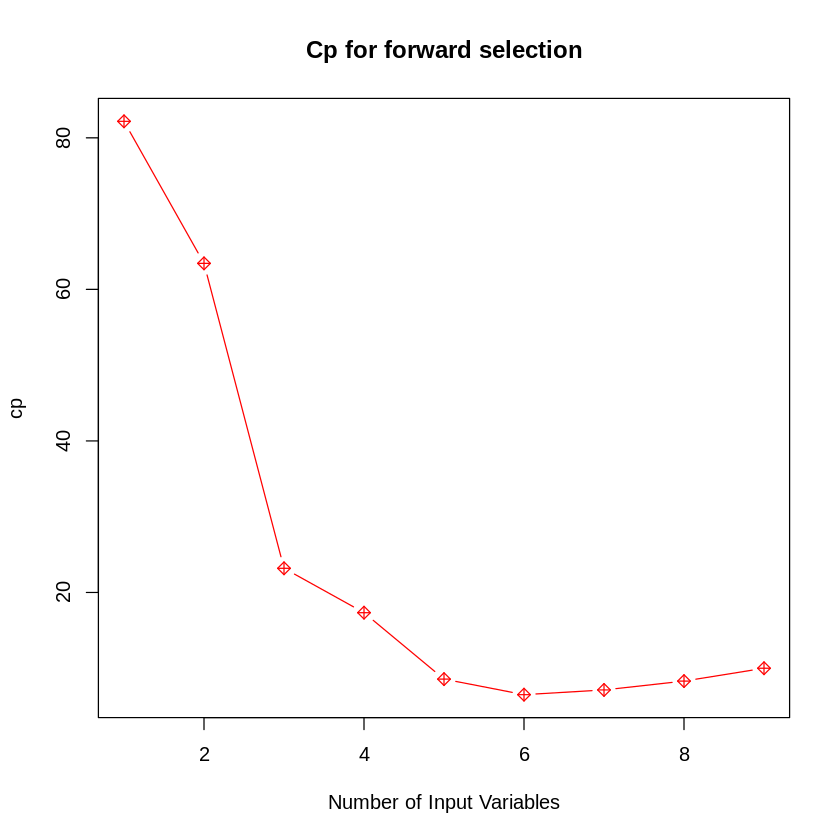

In [28]:
plot(summary(crime_forward_sel)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "cp", type = "b", pch = 9,
  col = "red"
)

*Figure 1.9 visualization of how Cp value change as input variables increase*

It is not hard to see the $ C_p $ value is the lowest when number of input variables is 6, so we know that the most accurate model is when we have 6 input variables.

Now, we will use the variables selected by the forward subset algorithm to build a predictive model with 6 input variables. We train the predictive model using `lm()` and the training set `crime_train`, and we name the model `crime_reduced_OLS`. We use `tidy()` function to obtain the estimated coefficients, their standard errors, corresponding $p$-values, $95\%$ confidence intervals, and store these results in `crime_reduced_OLS_results`.

In [29]:
crime_reduced_OLS <- lm(formula = log_totCrimesPerPop ~ popComm + pctUrban + pctUnderPov + pctNotHSGrad + pctDiv + meanPerFam, data = crime_train)

crime_reduced_OLS_results <- tidy(crime_reduced_OLS)
crime_reduced_OLS_results


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-3.4999687,0.2517517,-13.902462,1.224285e-30
popComm,0.8328867,0.2748503,3.030328,2.788860e-03
pctUrbannon-urban,-0.2508091,0.1244372,-2.015547,4.527891e-02
pctUnderPov,0.6449376,0.4019420,1.604554,1.102795e-01
pctNotHSGrad,1.2795873,0.3597645,3.556736,4.757640e-04
pctDiv,1.9470576,0.3094472,6.292052,2.168752e-09
meanPerFam,0.6475134,0.3178915,2.036901,4.306956e-02


*Table 1.14 Results of predictive addtive model with 6 input variables*

Same as we did for full OLS regression, we use `predict()` function and the reduced predictive LR `crime_reduced_OLS` to obtain the out-of-sample predicted values of total number of violent crimes per 100K popuation in testing data `crime_test`.  We store the predicted values in a variable called `test_crime_reduced_OLS`. We will look at the first few predicted value using `head()` function.

In [30]:
test_crime_reduced_OLS <- predict(crime_reduced_OLS, newdata = crime_test)

head(test_crime_reduced_OLS)

1          2          3          4          5          6 
-1.3689204 -0.7581797 -1.1174175 -2.0554149 -1.8970850 -2.0666780

Then, we use `rmse()` function to compute the RMSE of predcited values stored in `test_crime_reduced_OLS` and add this metric as another row in the tibble `crime_R_MSE_pred_models` with `OLS Reduced Regression` in the column `Model` and the corresponding $\text{RMSE}_{\text{test}}$ in the column `R_MSE`.

In [31]:
crime_R_MSE_pred_models <- rbind(
    crime_R_MSE_pred_models,
    tibble(
        Model = "OLS Reduced Regression",
        R_MSE = rmse(
            preds = test_crime_reduced_OLS,
            actuals = crime_test$log_totCrimesPerPop)))
crime_R_MSE_pred_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,0.4123482
OLS Reduced Regression,0.4398280


*Table 1.15 RMSE obtained from full OLS and reduced OLS regression*

Based on our results in `crime_R_MSE_pred_models`, OLS full regression model gives better out-of-sample prediction performance since the smaller the metric `R_MSE` the better the model (0.412 is smaller than 0.440). So far, we conclude that OLS full regression model is the best predictive model. 

#### LASSO Model

In this part, we want to study LASSO model to see if LASSO model could give us a better prediction performance than the previous two models.  

First of all, we will replace the words `non-urban` and `urban` in the categorical variable `pctUrban` with number `0` and `1` to make sure we can use our categorical variable in LASSO model. We do this in both training set and testing set.

In [32]:
crime_train <- crime_train %>%
    mutate(pctUrban = if_else(pctUrban == "urban", 1, 0))

crime_test <- crime_test %>%
    mutate(pctUrban = if_else(pctUrban == "urban", 1, 0))

head(crime_train)

popComm,agePct16t24,pctUrban,perCapInc,pctUnderPov,pctNotHSGrad,pctUnemployed,pctDiv,meanPerFam,log_totCrimesPerPop
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.07,0.31,1,0.56,0.08,0.14,0.17,0.35,0.72,-1.6607312
0.20,0.43,1,0.19,0.49,0.71,0.60,0.51,1.00,-0.4004776
0.04,0.45,1,0.45,0.16,0.17,0.07,0.62,0.31,-1.0216512
0.02,0.25,1,0.77,0.08,0.09,0.18,0.40,0.66,-1.8971200
0.02,0.23,0,0.33,0.20,0.22,0.21,0.61,0.49,-1.9661129
0.55,0.37,1,0.22,0.64,0.54,0.56,0.67,0.70,-0.5276327


*Table 1.16 first six rows of training set after we replace non-urban and urban with 0 and 1 in categorical variable*

To train a regression using LASSO, we will use the package `glmnet`, which requires a matrix with input variables and a vector of responses. 
Thus, we use `as.matrix` function to prepare the model matrix for `glmnet`. We create 4 matrix, which are the training x-matrix `crime_train_X` and training y-matrix `crime_train_Y`; the testing x-matrix `crime_test_X` and testing y-matrix `crime_test_Y`.

In [33]:
crime_train_X <- crime_train %>% select(- "log_totCrimesPerPop") %>% as.matrix()
crime_train_Y <- crime_train %>% select("log_totCrimesPerPop") %>% as.matrix()

crime_test_X <- crime_test %>% select(- "log_totCrimesPerPop") %>% as.matrix()
crime_test_Y <- crime_test %>% select("log_totCrimesPerPop") %>% as.matrix()

With the training data `crime_train_X` and `crime_train_Y`, we use `cv.glmnet` function to find an "optimal" value of $\lambda$ value for our LASSO model. In `cv.glmnet` function, we set `alpha = 1` as we want to get a LASSO model. We want to see the results and find the value `lambda` that provides the lowest Cross-validation MSE.

Below that, we use `plot()` function to visualize how the estimated test-MSE changes for different values of $\lambda$.


Call:  cv.glmnet(x = crime_train_X, y = crime_train_Y, lambda = exp(seq(-5,      0, 0.1)), alpha = 1) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.00674    51  0.2780 0.05351       8
1se 0.11080    23  0.3267 0.05362       6

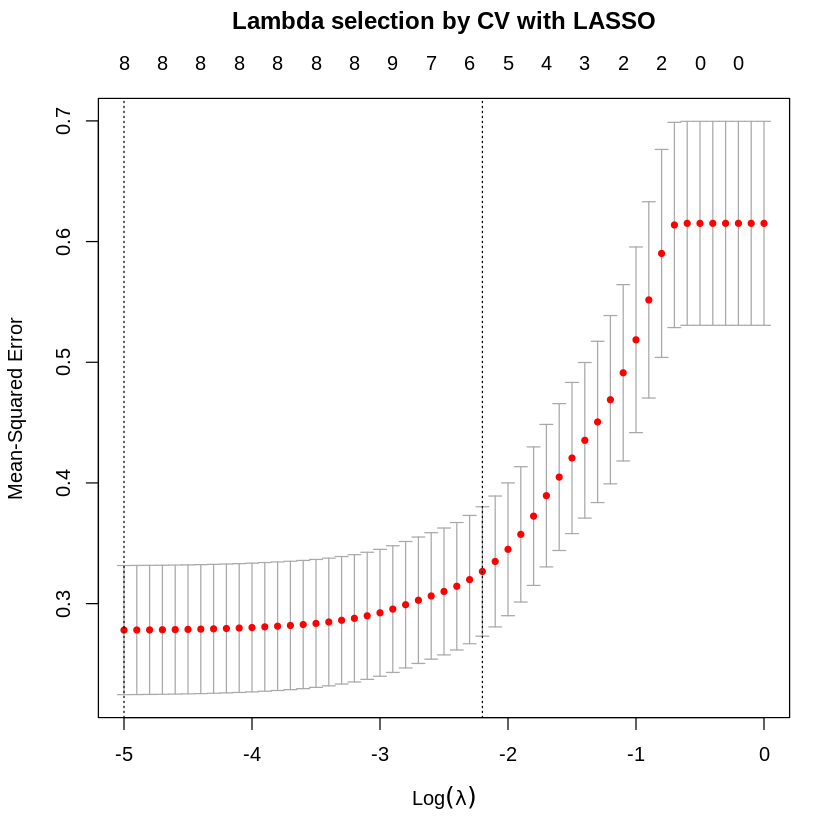

In [34]:
crime_cv_lambda_LASSO <- cv.glmnet(
    x = crime_train_X, 
    y = crime_train_Y,
    alpha = 1,
    lambda = exp(seq(-5, 0, 0.1)))

crime_cv_lambda_LASSO

plot(crime_cv_lambda_LASSO, main = "Lambda selection by CV with LASSO\n\n")

*Figure 1.10 Plot of changing MSE for different Lambda*

The figure above shows the estimated test-MSE for a grid of values of 𝜆 on the natural log-scale.
The numbers at the top 𝑥 -axis indicate the number of inputs whose estimated coefficients are different from zero for different values of 𝜆 .
The error bars represent the variation across the different test sets of the CV (folds).

The two vertical dotted lines correspond to two values of 𝜆, which are the $\hat{\lambda}_{\text{min}}$ and the $\hat{\lambda}_{\text{1SE}}$. The $\hat{\lambda}_{\text{min}}$ provides the minimum MSE in the grid, and the $\hat{\lambda}_{\text{1SE}}$ is largest value of lambda such that the corresponding MSE is within 1 standard error of that of the minimum.

From both of our results and plot, we learn that `lambda` is the lowest when we use 8 input variables in the LASSO model. 

Then we use `coef()` function to see which 8 variables will be used in LASSO model.

In [35]:
beta_crime_lasso <- coef(crime_cv_lambda_LASSO, 
                         crime_cv_lambda_LASSO$lambda.min)

beta_crime_lasso

10 x 1 sparse Matrix of class "dgCMatrix"
                       s1
(Intercept)   -3.74201847
popComm        0.85489158
agePct16t24    0.31595109
pctUrban       0.26554657
perCapInc      .         
pctUnderPov    0.09735634
pctNotHSGrad   1.11746094
pctUnemployed  0.59745895
pctDiv         1.85922723
meanPerFam     0.47940534

We round the $\hat{\lambda}_{\text{min}}$ into 4 decimal places and store the value as `crime_lambda_min_MSE_LASSO`, which will be used to create our LASSO model.

In [36]:
crime_lambda_min_MSE_LASSO <- round(crime_cv_lambda_LASSO$lambda.min, 4)

crime_lambda_min_MSE_LASSO

[1] 0.0067

After finding the $\lambda$ with the minimum MSE in the grid, we use it as our lambda value to create our Lasso model with `glmnet` function.

In [37]:
crime_cv_lambda_LASSO <- glmnet(
    x = crime_train_X, 
    y = crime_train_Y,
    alpha = 1,
    lambda = crime_lambda_min_MSE_LASSO)

We use `predict()` function and the LASSO model `crime_cv_lambda_LASSO` to obtain the out-of-sample predicted values of total number of violent crimes per 100K popuation in testing matrix set `crime_test_X`.  We store the predicted values in a variable called `crime_test_pred_LASSO_min`. We will look at the first few predicted value using `head()` function.

In [38]:
crime_test_pred_LASSO_min <- predict(crime_cv_lambda_LASSO, newx = crime_test_X)
head(crime_test_pred_LASSO_min)

s0
-1.3805223
-0.7330767
-1.1459752
-2.0105054
-1.9163451
-2.0943750


*Table 1.17 Predicted values from LASSO model*

Finally, we use `rmse()` function to compute the RMSE of predcited values stored in `crime_test_pred_LASSO_min` and add this metric as another row in the tibble `crime_R_MSE_pred_models` with `LASSO Regression with minimum MSE` in the column `Model` and the corresponding $\text{RMSE}_{\text{test}}$ in the column `R_MSE`. 


Now, we have obtained the `R_MSE` of the `OLS Full Regression` model, the `OLS Reduced Regression` model (create by forward selection) and the `LASSO Regression with minimum MSE` model.


In [39]:
crime_R_MSE_pred_models <- rbind(crime_R_MSE_pred_models,
    tibble(
    Model = "LASSO Regression with minimum MSE",
    R_MSE = rmse(
        preds = crime_test_pred_LASSO_min,
        actuals = crime_test$log_totCrimesPerPop)))
crime_R_MSE_pred_models

Model,R_MSE
<chr>,<dbl>
OLS Full Regression,0.4123482
OLS Reduced Regression,0.4398280
LASSO Regression with minimum MSE,0.4404912


*Table 1.18 RMSE obtained from full OLS, reduced OLS regression and LASSO model*

Comparing the RMSE of 3 models in `crime_R_MSE_pred_models`, the `OLS Full Regression` model has the smallest RMSE, which gives the best out-of-sample prediction performance, so based on our results, the `OLS Full Regression` model is the best fit model to conduct the prediction.

## Discussion

## Reference

**References**

Daigle, Leah E.; Hancock, Katelyn; Chafin, Travis C.; Azimi, Andia. (2021). U.S. and Canadian College Students’ Fear of Crime: A Comparative Investigation of Fear of Crime and Its Correlates. *Journal of Interpersonal Violence 37(15-16).* https://doi.org/10.1177/08862605211001477 

 
National Research Council. (2008). *Understanding Crime Trends: Workshop Report.* Washington, DC: The National Academies Press. https://doi.org/10.17226/12472 


Federal Bureau of Investigation: Uniform Crime Report. (December, 2012). *Variables Affecting Crime.* Hate Crime Statistics. https://ucr.fbi.gov/hate-crime/2011/resources/variables-affecting-crime
 

**Reference for Dataset**
 
Michael Redmond. (2009). *Communities and Crime Data Set.* UCI Machine Learning Repository Irvine, CA: the University of California, School of Information and Computer Science. https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime
